In [1]:
# Needed base libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

# Hide warnings
import warnings
# Ignore all future warnings to clean up output
warnings.simplefilter(action='ignore', category=FutureWarning)
# Ignore all warnings to further clean up output
warnings.simplefilter(action='ignore', category=Warning)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import optimizers as tfko
from keras.callbacks import EarlyStopping

# Import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.model_selection import KFold

# ***Breast cancer classification of Diagnostic Wisconsin Breast Cancer database***

The data that will be analyzed in this project comes from the **"Breast Cancer Wisconsin (Diagnostic)" dataset**.

This data was used with the goal of creating a more accurate and non-invasive breast cancer diagnostic tool, done by combining image processing and machine learning, as described in the paper "Nuclear feature extraction for breast tumor diagnosis" (By W. Street, W. Wolberg, O. Mangasarian. 1993).

The dataset contains information extracted from digitalized images of fine needle aspirate (FNA) of breast mass. Each tumor cell has its boundary detected, then 10 features are extracted from it.

These features are calculated for each cell nucleus in 3 categories:
- Mean Value for the cell
- Measure of variation
- Mean of 3 largest values

This results in the dataset having in total 30 numeric features



In [2]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
X = data.data
y = data.target

In the data we have:
- X: the features extracted
- y: the label of the cell, either benign or malignant

If a cell is **benign**, it means that the cell has a non-cancer tumor.
On the other hand, if a cell is **malignant**, it means that the cell has a cancer tumor.

From the information available about the dataset, we know that these two classes are already mostly balanced, since there are:
- 357 benign samples
- 212 malignant samples

In [3]:
# Convert the data and target into a Pandas DataFrame
df = pd.DataFrame(data=data.data, columns=data.feature_names)
df['target'] = data.target

df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [4]:
df["target"].value_counts()

,count
target,
1,357
0,212


From the code above, now we know that:
- 1: benign tumor
- 0: malignant tumor

## Goal of the project

The goal of the project is to create a Neural Network for breast Cancer Classification, more precisely, we want to implement a Multilayer Perceptron.

The model has to avoid overfitting (as well as underfitting) and has to be generalizable to other data.

## Data preprocessing

### Exploring the data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

From the code above, we get to know the following:
- There are no null values (this was also said in the dataset description)
- All the data used to understand the target is a float number, which might need normalization
- The only integer numbers are those referring to the labels (as mentioned above)

From these statements we get to know that there is no need for preprocessing of categorical values, since there are none.

In [6]:
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


In the table above, the descriptive statistics can be visualized for each attribute

### Normalization

In [7]:
min_df = df.min()
max_df = df.max()

# Normalise the dataset splits in the range [0,1]
df = (df - min_df)/(max_df - min_df)

df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,0.605518,...,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864,0.0
1,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,0.141323,...,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878,0.0
2,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,0.211247,...,0.360075,0.508442,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433,0.0
3,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,1.000000,...,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.884880,1.000000,0.773711,0.0
4,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,0.186816,...,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595,0.0


## Data partitioning

In the code below, the data will be partitioned into:
- Train set
- Validation set
- Test set

In [8]:
X = df.drop('target', axis=1) # Data
y = df['target'] # Label

print(X.shape)
print(y.shape)

(569, 30)
(569,)


In [9]:
# Amount of shuffling of the data
seed = 42

# Split the dataset into a combined training and validation set, and a separate test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, # data
    y, # labels
    test_size = 0.2,
    random_state=seed,
    stratify=y
)

# Further split the combined training and validation set into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size = len(X_test), # Ensure validation set size matches test set size
    random_state=seed,
    stratify=y_train_val
)

# Print the shapes of the resulting datasets
print(f"Shape of X_train: {X_train.shape}, Shape of y_train: {y_train.shape}")
print(f"Shape of X_val: {X_val.shape}, Shape of y_val: {y_val.shape}")
print(f"Shape of X_test: {X_test.shape}, Shape of y_test: {y_test.shape}")

Shape of X_train: (341, 30), Shape of y_train: (341,)
Shape of X_val: (114, 30), Shape of y_val: (114,)
Shape of X_test: (114, 30), Shape of y_test: (114,)


Now we can plot the amount of datapoints assigned to each label in each set. Our goal was to have the same amount of "1" labels and "0" labels in each set for consistency.

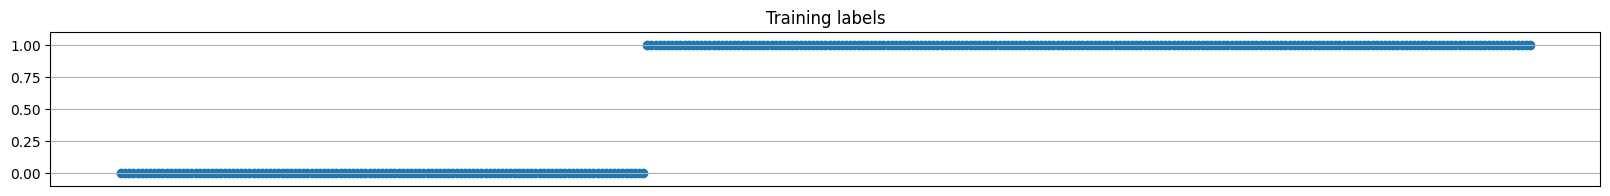

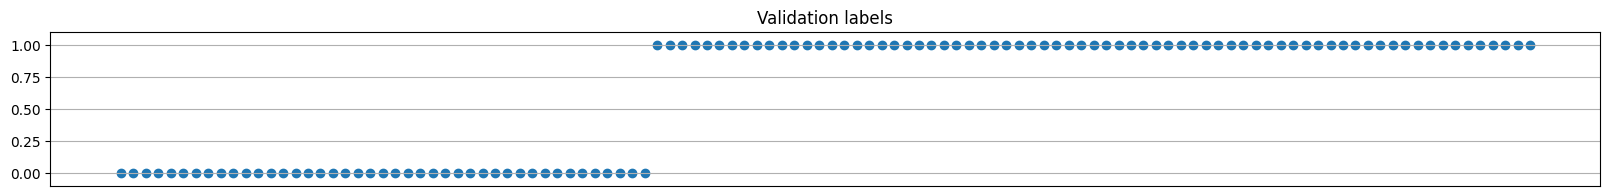

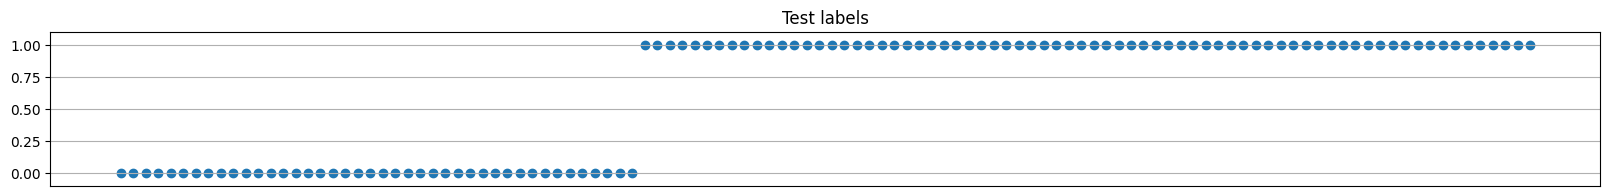

In [10]:
# Visualize the sorted target variable values for the training, validation, and test sets

# Training labels subplot
plt.figure(figsize=(20, 2))
plt.scatter(np.arange(len(y_train)), np.sort(y_train, axis=0))
plt.title('Training labels')
plt.xticks([])          # Remove x-axis ticks
plt.grid(0.2)           # Add a grid with opacity 0.2 for reference
plt.ylim([-0.1, 1.1])   # Set the y-axis limits to [0.1, 1.1]

# Validation labels subplot
plt.figure(figsize=(20, 2))
plt.scatter(np.arange(len(y_val)), np.sort(y_val, axis=0))
plt.title('Validation labels')
plt.xticks([])          # Remove x-axis ticks
plt.grid(0.2)           # Add a grid with opacity 0.2 for reference
plt.ylim([-0.1, 1.1])   # Set the y-axis limits to [0.1, 1.1]

# Create a figure for the test labels subplot
plt.figure(figsize=(20, 2))
plt.scatter(np.arange(len(y_test)), np.sort(y_test, axis=0))
plt.title('Test labels')
plt.xticks([])          # Remove x-axis ticks
plt.grid(0.2)           # Add a grid with opacity 0.2 for reference
plt.ylim([-0.1, 1.1])   # Set the y-axis limits to [0.1, 1.1]

# Display the plots
plt.show()

## Multilayer Perceptron implementation

As for the model, the **Multilayer Perceptron (MLP)** was chosen. The model was created using the following layers:
- **Input layer**: entry point of our data, defines the expected shape of data
- **Dense layer**: Fully connected layer with 256 neurons (before optimization)
- **Activation function**: determines if a single neuron should be activated, going from an input signal to an output signal
- **Dropout layer**: sets 30% of the neurons to 0 (before optimization), prevents overfitting
- **Output layer**: the final layer of the neural network, responsible for the value given to the output activation function
- **Output activation**: produces the model prediction

Afterwards, we have to compile the model by defining:
- **Loss function**: calculates the difference between the model prediction and the model's actual label, it guides the optimization. In this case, the Binary Cross Entropy was chosen, because it is the technique most used in binary classification problems
- **Learning rate scheduler**: reduce the learning rate value during the training, this technique is also used to avoid overfitting
- **Optimizer**: used to optimize the weights and the biases, in the case the optimizer chosen is the Stochastic Gradient Descent, since it is great for generalization

Finally, the hyperparameters of the model are:
- **Learning rate**: how much the model parameters are learned during training
- **Number of hidden layers**: controls the model complexity, which can be useful to manipulate the ability of the model to generalize
- **Dropout rate**: percentage of neurons deactivated

In [11]:
def MultiLayerPerceptron(
    input_shape,          # Shape of the input data
    seed=seed,            # Seed for reproducibility, defaults to previously set seed
    learning_rate=0.01,   # Set the learning rate for the optimizer
    num_hiddenLayers=256, # Number of hidden layers
    dropout_rate=0.3      # Dropout rate for regularization
):
    # Fix randomness
    tf.random.set_seed(seed)  # Set TensorFlow's random seed for reproducibility
                              # Make weight draws reproducible

    # Build the model layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input') # Input layer
    x = tfkl.Dense(units= num_hiddenLayers, kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='HiddenDense1')(input_layer) # Fully connected layer
    x = tfkl.Activation('relu', name='HiddenActivation1')(x) # Activation function
    x = tfkl.Dropout(dropout_rate, name='Dropout1')(x) # Dropout layer to prevent overfitting
    x = tfkl.Dense(units= num_hiddenLayers, kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='HiddenDense2')(x) # Fully connected layer
    x = tfkl.Activation('relu', name='HiddenActivation2')(x) # Activation function
    x = tfkl.Dropout(dropout_rate, name='Dropout2')(x) # Dropout layer to prevent overfitting
    output_layer = tfkl.Dense(units=1, name='Output')(x) # Output layer with 1 unit (for binary classification)
    output_activation = tfkl.Activation('sigmoid', name='Sigmoid')(output_layer) # Sigmoid activation function to the output layer

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_activation, name='Perceptron')

    # Define the loss
    loss = tfk.losses.BinaryCrossentropy()  # Define binary cross-entropy loss

    # Define the optimizer
    lr_schedule = tfko.schedules.ExponentialDecay(
        initial_learning_rate=learning_rate,
        decay_steps=1000, # Number of steps after which to apply the decay rate to the learning rate
        decay_rate=0.96,  # Multiplied to the learning rate it reduces it
        staircase=True    # if True, learning rate decays in discrete intervals
    )
    optimizer = tfk.optimizers.SGD(lr_schedule)  # Use stochastic gradient descent as the optimizer

    # Define the metric
    metrics = ['accuracy']  # Track accuracy as a metric

    # Compile the model
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)  # Compile the model with specified loss, optimizer, and metrics
    # Compilation specifies several key components that define how the model will learn and evaluate its performance

    # Return the model
    return model

In [12]:
# Determine the input shape for the neural network,
# which corresponds to the number of features in the input data
input_shape = X_train.shape[1:]
print(f'Input shape of the network {input_shape}')

Input shape of the network (30,)


Model: "Perceptron"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenDense1 (Dense)            │ (None, 256)            │         7,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenActivation1 (Activation)  │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout1 (Dropout)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenDense2 (Dense)            │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenActivation2 (Activation)  │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout2 (Dropout)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │           257 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Sigmoid (Activation)            │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,985 (289.00 KB)

 Trainable params: 73,985 (289.00 KB)

 Non-trainable params: 0 (0.00 B)

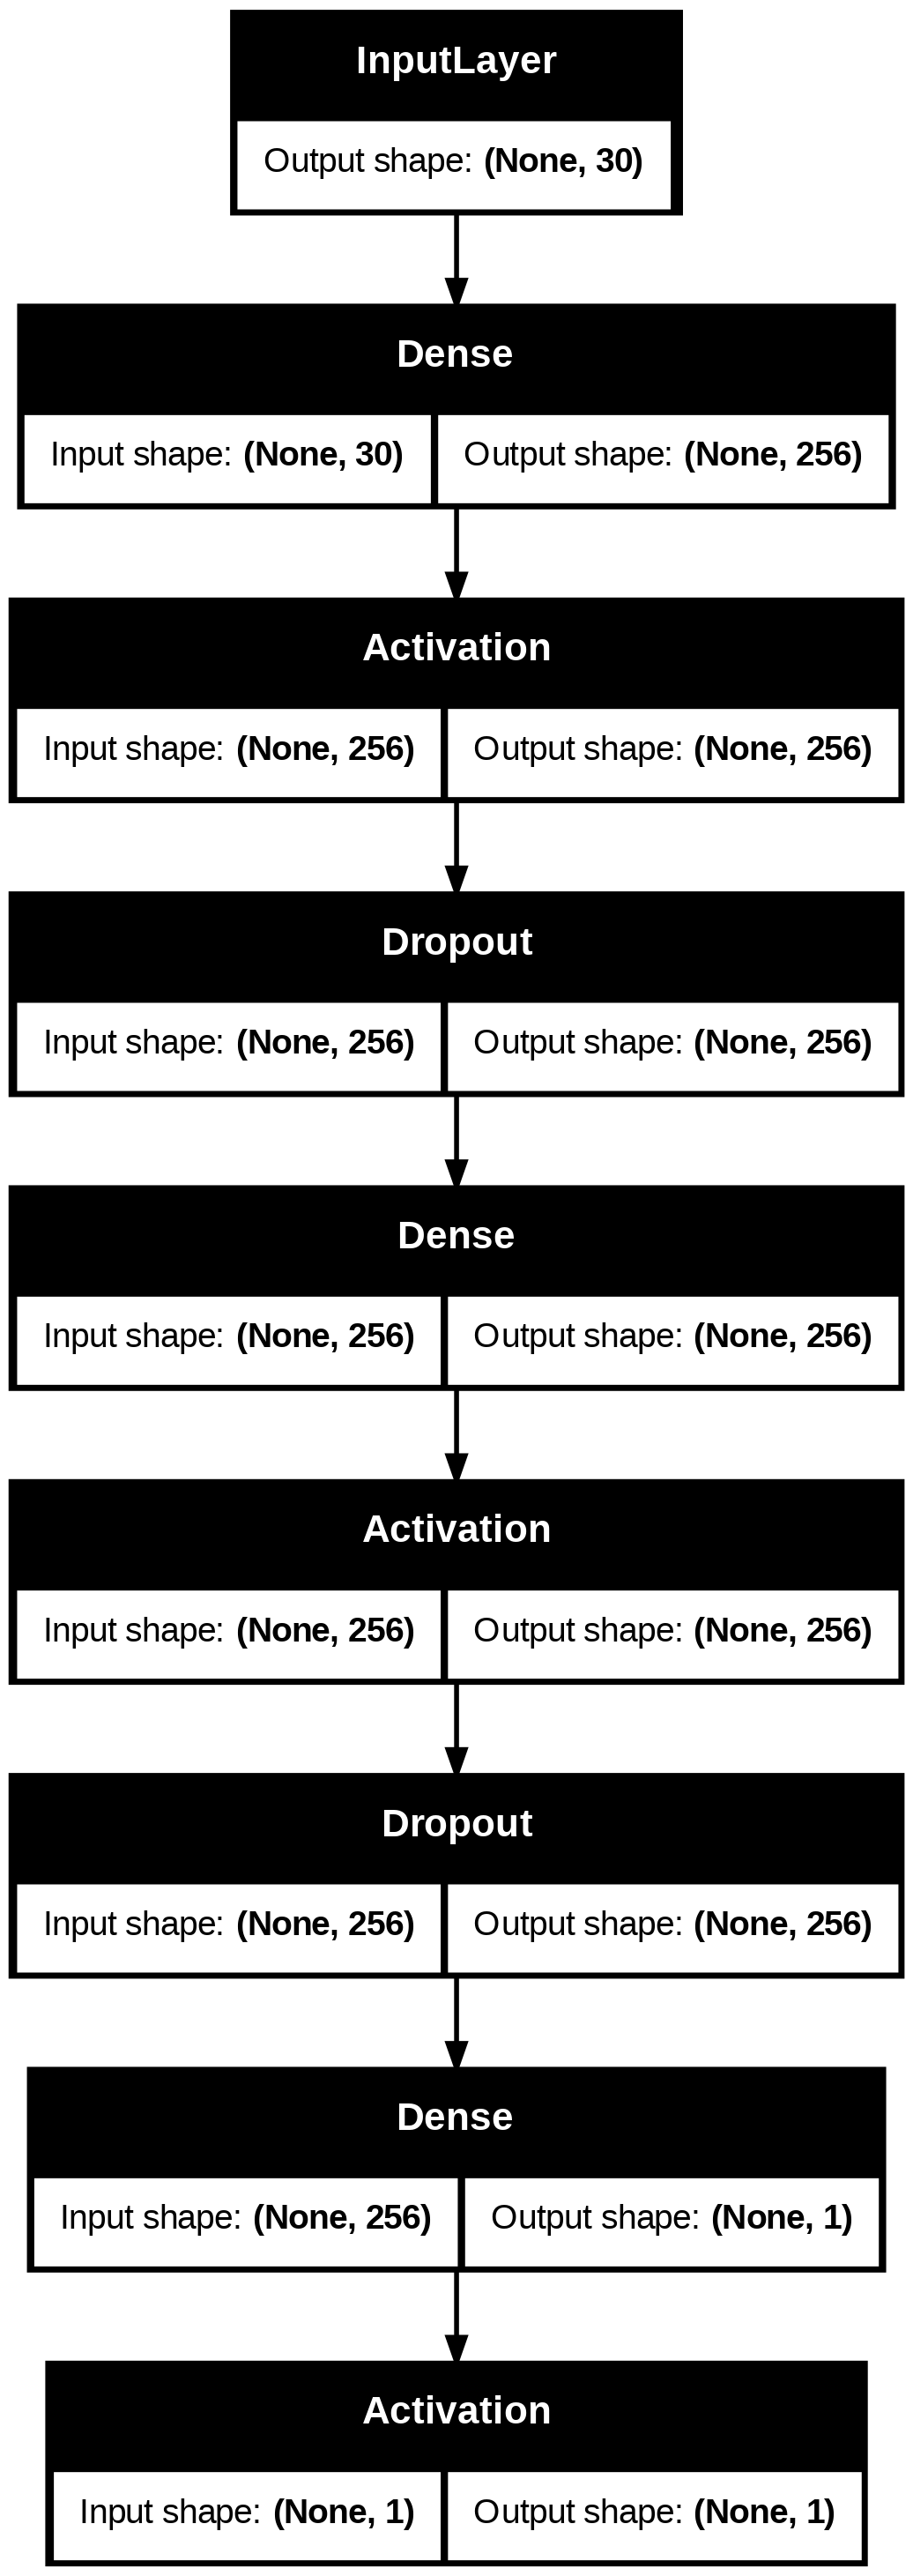

In [13]:
model = MultiLayerPerceptron(input_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

## Training loop of the model

### Define early stopping

**Early stopping**: stopping criterion that halts training once a metric (in this case validation loss) stops improving.

When using early stopping, the model trains until there is no more a meaningful improvement.

In [14]:
es = EarlyStopping(monitor='val_loss', # Metric being observed
                   mode='min',         # Defines that the values has to be strictly less than the previous one
                   patience= 40,       # How many epochs without improvement happen before the training actually stops
                   restore_best_weights = True)  # To use the weight values that yield the lowest "val_loss"

### Train the model

The model is trained using both early stopping and cross validation

In [15]:
history = model.fit(X_train, y_train,
                    validation_data = (X_val, y_val),
                    callbacks=[es],
                    epochs=5000,
                    batch_size=128,
                    verbose=1)

Epoch 1/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 828ms/step - accuracy: 0.5471 - loss: 0.6835 - val_accuracy: 0.6754 - val_loss: 0.6564
Epoch 2/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5730 - loss: 0.6764 - val_accuracy: 0.7544 - val_loss: 0.6501
Epoch 3/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5945 - loss: 0.6550 - val_accuracy: 0.7719 - val_loss: 0.6447
Epoch 4/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5945 - loss: 0.6660 - val_accuracy: 0.8246 - val_loss: 0.6390
Epoch 5/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6146 - loss: 0.6612 - val_accuracy: 0.8333 - val_loss: 0.6339
Epoch 6/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5887 - loss: 0.6657 - val_accuracy: 0.8246 - val_loss: 0.6292
Epoch 7/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6478 - loss: 0.6412 - val_accuracy: 0.8246 - val_loss: 0.6244
Epoch 8/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6971 - loss: 0.6265 - val_accuracy: 0.8246 - 

### Save the model

In [16]:
# Save the baseline model to a file
model.save('BaselineModel.keras')

# Delete the current model
del model

# Load the saved baseline model
model = tfk.models.load_model('BaselineModel.keras')

## Evaluation of the results (model w/out optimiziation)

### Plot of the learning curves

#### Training loss and validation loss

The learning curves that are most meaningful in this application are:
- Training loss
- Validation loss

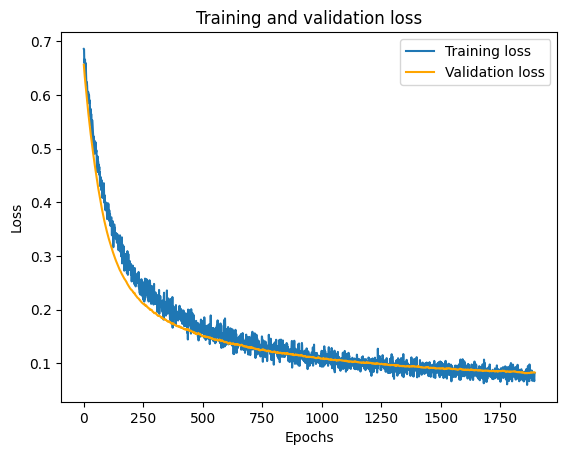

In [17]:
# let's see the training and validation accuracy by epoch
history_dict = history.history
loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this
epochs = range(1, len(loss_values) + 1) # range of X (no. of epochs)
plt.plot(epochs, loss_values, label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The plot shows that at the beggining of the simulation the model learns quite quickly (until the epoch 250). Afterwards, there is a gradual decay in the amount of learning, with the training loss being quite jaggered due to the fact that we use the SGD as the optimizer (which works on mini-batches). Finally, the curve flattens out, showing that we are reaching convergence.

The training loss and the validation loss stay quite close, meaning that, most likely, the model will be good in generalizing and will avoid overfitting.

#### Comparison between the training loss and the accuracy throughout the epochs

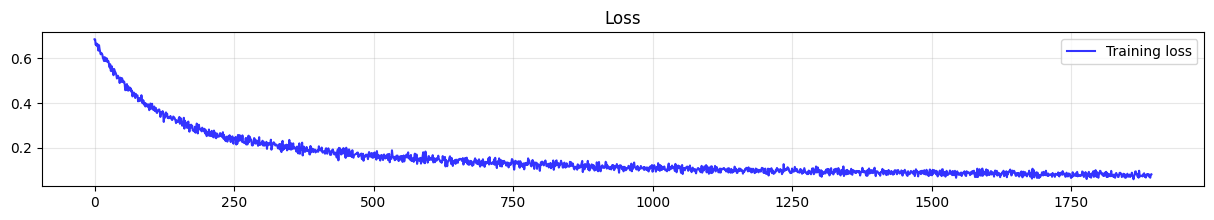

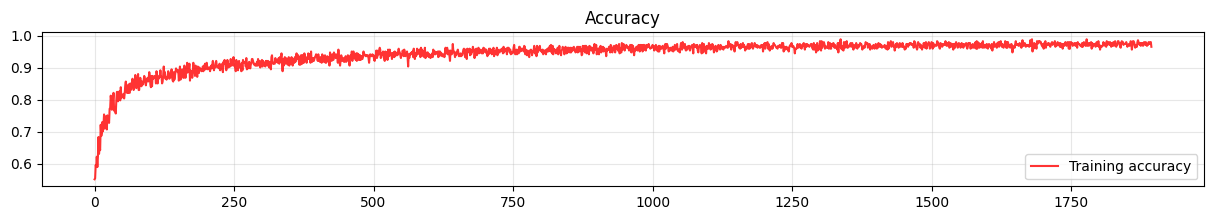

In [18]:
# Create a figure for the loss plot with specified figsize
plt.figure(figsize=(15, 2))

# Plot the training loss from the training history
plt.plot(history_dict['loss'], label='Training loss', alpha=.8, color='blue')

# Set title for the plot
plt.title('Loss')

# Add a legend to the plot
plt.legend()

# Add grid lines to the plot with specified transparency
plt.grid(alpha=.3)

# Create a new figure for the accuracy plot with specified figsize
plt.figure(figsize=(15, 2))

# Plot the training accuracy from the training history
plt.plot(history_dict['accuracy'], label='Training accuracy', alpha=.8, color='red')

# Set title for the plot
plt.title('Accuracy')

# Add a legend to the plot
plt.legend()

# Add grid lines to the plot with specified transparency
plt.grid(alpha=.3)

# Display the plots
plt.show()

The graph shows that as the training loss diminishes, the training accuracy increases. This is an idicator that the model is working correctly.

### Performance on the different sets

#### Accuracy on the different sets

In all the following cases, the threshold value to distinguish between the label 1 and 0 is 0.5

In [19]:
# Training set prediction
raw_predictions_train = model.predict(X_train, verbose=0)
train_predictions = (raw_predictions_train > 0.5).astype(int).squeeze()

train_accuracy = accuracy_score(y_train, train_predictions)
print(f'Training accuracy: {train_accuracy}')

Training accuracy: 0.9853372434017595


In [20]:
# Validation set prediction
raw_predictions_val = model.predict(X_val, verbose=0)
val_predictions = (raw_predictions_val > 0.5).astype(int).squeeze()

val_accuracy = accuracy_score(y_val, val_predictions)
print(f'Validation accuracy: {val_accuracy}')

Validation accuracy: 0.9824561403508771


In [21]:
# Test set prediction
raw_predictions_test = model.predict(X_test, verbose=0)
test_predictions = (raw_predictions_test > 0.5).astype(int).squeeze()

test_accuracy = accuracy_score(y_test, test_predictions)
print(f'Test accuracy: {test_accuracy}')

Test accuracy: 0.9736842105263158


These results prove that the model has a good performance, while avoiding overfitting or underfitting. This means that the model has a good fit and is able to generalize to unknown data.

To have a more accurate idea of what threshold value should be used, the ROC curve can be used

In [22]:
# False‐positive rate: fpr
# True‐positive rate: tpr
# Thresholds: T

def plot_ROC(y_true, y_pred):
  fpr, tpr, thresholds = roc_curve(y_true, y_pred)
  roc_auc = auc(fpr, tpr)

  plt.figure(figsize=(6, 6))
  plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})', linewidth=2)
  plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random chance (AUC = 0.5)')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.legend(loc='lower right')
  plt.grid(alpha=0.3)
  plt.show()


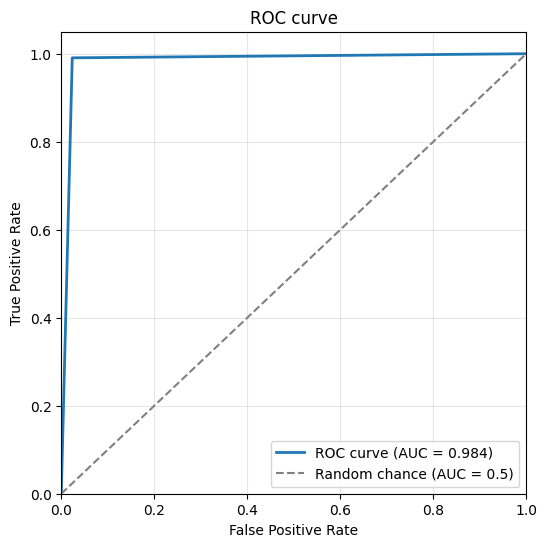

In [23]:
plot_ROC(y_train, train_predictions)

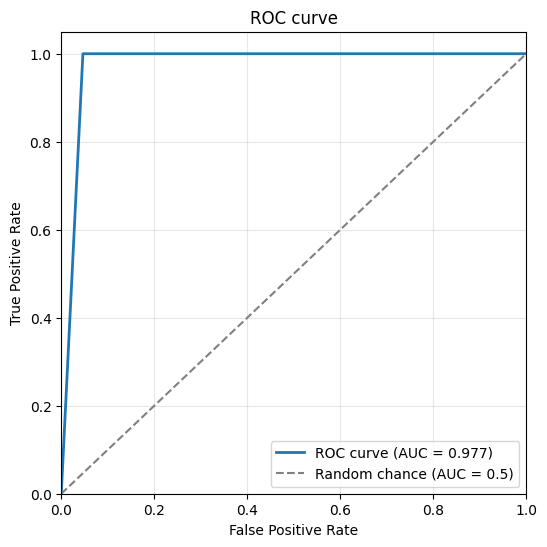

In [24]:
plot_ROC(y_val, val_predictions)

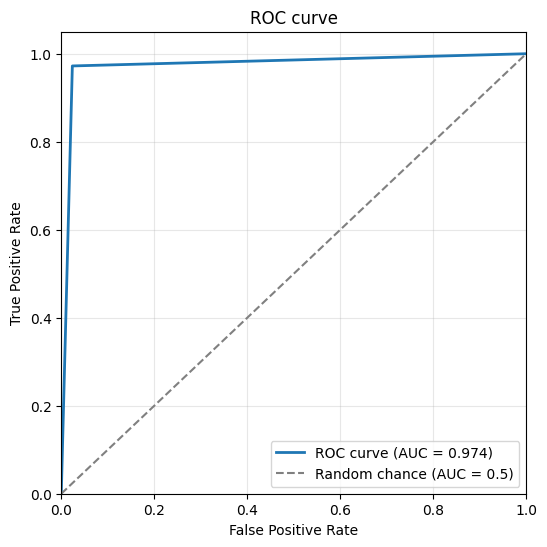

In [25]:
plot_ROC(y_test, test_predictions)

The graphs reported above show that for the threshold chosen, 0.5, the model is able to report more that 0.9 true predicted labels, meaning that more that 90% of the predictions were classified correctly

Therefore, the closer the ROC curve is to the top-left corner of the graph, the better the classifier is able to achieve high true-positive predictions (TPR) and low false-positive predictions(FPR).

#### F1-score on the different sets

Other than accuracy, an important metric to use in this case is the f1-score, becasue the data is sligthly unbalanced.

The f1-score is the harmonic mean between recall and precision, defining a more meaningful metric for the evaluation of a model.

In [26]:
train_f1 = f1_score(y_train, train_predictions)
print(f'Training f1-score: {train_f1}')

Training f1-score: 0.9883449883449883


In [27]:
val_f1 = f1_score(y_val, val_predictions)
print(f'Validation f1-score: {val_f1}')

Validation f1-score: 0.9861111111111112


In [28]:
test_f1 = f1_score(y_test, test_predictions)
print(f'Test f1-score: {test_f1}')

Test f1-score: 0.9790209790209791


Also the f1-scores shows the good performance of the model, highlighting its ability to correctly classify unknown instances, hence its ability of generalizing

### K-fold Cross validation

When training a model, the partitioning of the data in just 3 fixed sets can be misleading, because the partitioning might be "lucky" (which makes the model seem better than what it actually is) or "unfortunate" (making the model seem worse than what it actually is).

To avoid this we can use k-fold cross validation, so that the model is splitted multiple times and reports the average scoring after each iteration. The final average score is less sensitive to the different data splits.

In [29]:
# Define the number of folds for cross-validation
num_folds = 8

# Initialize lists to store training histories, scores, and best epochs
histories = []
scores = []
best_epochs = []

# Set parameters
batch_size = 128
epochs = 1000

# Create a KFold cross-validation object
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

# Loop through each fold
for fold_idx, (train_idx, valid_idx) in enumerate(kfold.split(X_train_val, y_train_val)):

  print("Starting training on fold num: {}".format(fold_idx+1))

  # Build a new dropout model for each fold
  k_model =  MultiLayerPerceptron(input_shape)

  es = EarlyStopping(monitor='val_loss', # Metric being observed
                   mode='min',         # Defines that the values has to be strictly less than the previous one
                   patience= 30,       # How many epochs without improvement happen before the training actually stops
                   restore_best_weights = True)  # To use the weight values that yield the lowest "val_loss"

  # Train the model on the training data for this fold
  history = k_model.fit(
    x = X_train_val.iloc[train_idx],
    y = y_train_val.iloc[train_idx],
    validation_data=(X_train_val.iloc[valid_idx], y_train_val.iloc[valid_idx]),
    batch_size = batch_size,
    epochs = epochs,
    callbacks = [es], # early stopping
    verbose = 0
  ).history

  # Evaluate the model on the validation data for this fold
  score = k_model.evaluate(X_train_val.iloc[valid_idx], y_train_val.iloc[valid_idx], verbose=0)
  scores.append(score[1])

  # Calculate the best epoch after early stopping
  best_epoch = len(history['loss'])
  best_epochs.append(best_epoch)

  # Store the training history for this fold
  histories.append(history)

Starting training on fold num: 1
Starting training on fold num: 2
Starting training on fold num: 3
Starting training on fold num: 4
Starting training on fold num: 5
Starting training on fold num: 6
Starting training on fold num: 7
Starting training on fold num: 8


Accuracy
Mean: 0.9758
Std:  0.0247


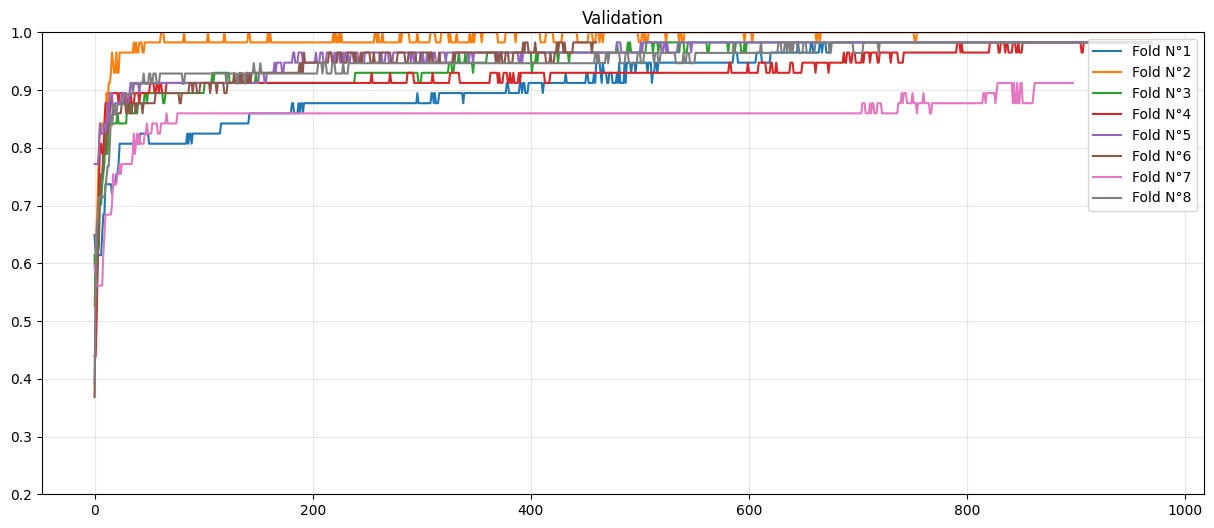

In [30]:
# Define a list of colors for plotting
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Print mean and standard deviation of accuracy scores
print("Accuracy")
print(f"Mean: {np.mean(scores).round(4)}\nStd:  {np.std(scores).round(4)}")

# Create a figure for Accuracy visualization
plt.figure(figsize=(15,6))

patience = 30

# Plot the accuracy for each fold
for fold_idx in range(num_folds):
  plt.plot(histories[fold_idx]['val_accuracy'][:-patience], color=colors[fold_idx], label=f'Fold N°{fold_idx+1}')
  plt.ylim(0.2, 1)
  plt.title('Validation')
  plt.legend(loc='upper right')
  plt.grid(alpha=.3)

# Show the plot
plt.show()

All the folds follow approximately the same pattern, showing consistency in the learning of the model.

Moreover, the mean of the accuracy of the folds is high, so really close to the accuracy on the data on which the model was trained, with a std that is very low (showing consistency as well).

Overall, the model is deemed very robust.

## Model Optimization


The goal of the model optimization is to do **hyperparameter tuning**. In fact, the hyper parameter settings can drastically change the results and the ability of the model to generalize.

The hyper-parameter tuning will be done using Grid Search combined with cross-validation (CV). For each candidate combination of hyperparameters we apply a k-fold cross validation, and then pick the combination of hyperparameters with the best average CV score.

### Grid search with cross-validation

In this case, the grid search will be used to check if we can reduce the complexity model while keeping the good performances.

This is very useful, because if the model is less complex, then it is also better at generalizing over unknown data.

In [31]:
# Setting the possible values of the hyperparameters
hyper_param = {
    'learning_rate': [0.01, 0.1],
    'num_hiddenLayers': [128, 256],
    'dropout_rate': [0.3, 0.5],
    'patience': [30, 50]
}

param_combinations = list(itertools.product(*hyper_param.values()))
print(f"Evaluate {len(param_combinations)} combinations \n")
# print(param_combinations) # List of tuples

Evaluate 16 combinations 



In [32]:
# Check the hyperparameters using the cross-validation
cv = 3 # Number of folds for cross-validation

# Initialize the best score, parametes and model
best_score = -np.inf # Ensure that the first model set a valid score
best_params = None

param_scores = []
count = 1

# Consider all combinations of hyperparameters
for set_param in param_combinations:
  print(f"Evaluating set of parameters number: {count}/{len(param_combinations)}")
  learning_rate = set_param[0]
  num_hiddenLayers = set_param[1]
  dropout_rate = set_param[2]
  patience = set_param[3]

  print(
      f"Learning rate: {learning_rate}\n"
      f"Number of hidden layers: {num_hiddenLayers}\n"
      f"Dropout rate: {dropout_rate}\n"
      f"Patience: {patience}\n"
  )

  histories = []
  scores_fold = []
  best_epochs = []

  # K-fold Cross-Validation
  kf = KFold(
    n_splits=cv,
    shuffle=True,
    random_state=seed)

  # Loop through each fold
  for fold_idx, (train_idx, valid_idx) in enumerate(kf.split(X_train_val, y_train_val)):
    print("Starting training on fold num: {}".format(fold_idx+1))

    # Build a new dropout model for each fold
    input_shape = X_train.shape[1:]

    k_model =  MultiLayerPerceptron(
        input_shape = input_shape,
        learning_rate = learning_rate,
        num_hiddenLayers = num_hiddenLayers,
        dropout_rate = dropout_rate
    )

    es = EarlyStopping(monitor='val_loss', # Metric being observed
                    mode='min',         # Defines that the values has to be strictly less than the previous one
                    patience= patience,       # How many epochs without improvement happen before the training actually stops
                    restore_best_weights = True)  # To use the weight values that yield the lowest "val_loss"

    # Train the model on the training data for this fold
    history = k_model.fit(
      x = X_train_val.iloc[train_idx],
      y = y_train_val.iloc[train_idx],
      validation_data=(X_train_val.iloc[valid_idx], y_train_val.iloc[valid_idx]),
      batch_size = batch_size,
      epochs = epochs,
      callbacks = [es], # early stopping
      verbose = 0
    ).history

    # Evaluate the model on the validation data for this fold
    score = k_model.evaluate(X_train_val.iloc[valid_idx], y_train_val.iloc[valid_idx], verbose=0)
    scores_fold.append(score[1])

    # Calculate the best epoch after early stopping
    best_epoch = len(history['loss'])
    best_epochs.append(best_epoch)

    # Store the training history for this fold
    histories.append(history)

  mean_fold = np.mean(scores_fold)
  print(f"Mean accuracy: {mean_fold:.4f}\n")
  param_scores.append(mean_fold)
  print("-"*100)

  count += 1

  if param_scores[-1] > best_score:
    best_score = param_scores[-1] # Update the mean_score
    best_params = set_param    # Update the parameters


Evaluating set of parameters number: 1/16
Learning rate: 0.01
Number of hidden layers: 128
Dropout rate: 0.3
Patience: 30

Starting training on fold num: 1
Starting training on fold num: 2
Starting training on fold num: 3
Mean accuracy: 0.9604

----------------------------------------------------------------------------------------------------
Evaluating set of parameters number: 2/16
Learning rate: 0.01
Number of hidden layers: 128
Dropout rate: 0.3
Patience: 50

Starting training on fold num: 1
Starting training on fold num: 2
Starting training on fold num: 3
Mean accuracy: 0.9648

----------------------------------------------------------------------------------------------------
Evaluating set of parameters number: 3/16
Learning rate: 0.01
Number of hidden layers: 128
Dropout rate: 0.5
Patience: 30

Starting training on fold num: 1
Starting training on fold num: 2
Starting training on fold num: 3
Mean accuracy: 0.9560

---------------------------------------------------------------

In [33]:
# The best parameters are the following:
print(f"Best parameters: {best_params}")
print(f"Best accuracy: {best_score:.4f}")

Best parameters: (0.1, 128, 0.3, 50)
Best accuracy: 0.9846


The combination of hyperparameters in the previous model was:
- learning_rate: 0.01
- num_hiddenLayers: 256
- dropout_rate: 0.3
- patience: 40

The hyperparameter tuning, on the other hand suggests to set the hyperparameters as follows:
- learning_rate: 0.1,
- num_hiddenLayers: 128,
- dropout_rate: 0.3
- patience: 50

The optimized model has a reduced complexity, since there are half of the hidden layers.

A surprising thing is that the learning rate is higher, which is unusual, but it is probably due to the fact that inside the model there is learning rate scheduler, so it diminishes throughout training.

Finally, it is not surprising that the patience is higher, because it allows the training to run a little longer, resulting in learning better weights.

### Training with the optimal parameters

Now that we have found the best parameters, we can train the model again with those and evaluate performance

In [34]:
# Getting the best parameters
best_learning_rate = best_params[0]
best_num_hiddenLayers = best_params[1]
best_dropout_rate = best_params[2]
best_patience = best_params[3]

In [35]:
# Input shape
input_shape = X_train.shape[1:]

In [36]:
# Defining the model with the best parameters
best_MLPmodel =  MultiLayerPerceptron(
  input_shape = input_shape,
  learning_rate = best_learning_rate,
  num_hiddenLayers = best_num_hiddenLayers,
  dropout_rate = best_dropout_rate
)

In [37]:
best_es = EarlyStopping(monitor='val_loss', # Metric being observed
                   mode='min',              # Defines that the values has to be strictly less than the previous one
                   patience= best_patience,       # How many epochs without improvement happen before the training actually stops
                   restore_best_weights = True)   # To use the weight values that yield the lowest "val_loss"

In [38]:
best_history = best_MLPmodel.fit(
    X_train,
    y_train,
    validation_data = (X_val, y_val),
    callbacks=[best_es],
    epochs=5000,
    batch_size=128,
    verbose=1
)

Epoch 1/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 920ms/step - accuracy: 0.4959 - loss: 0.6758 - val_accuracy: 0.9035 - val_loss: 0.6348
Epoch 2/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6493 - loss: 0.6528 - val_accuracy: 0.8596 - val_loss: 0.6097
Epoch 3/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6854 - loss: 0.6216 - val_accuracy: 0.8860 - val_loss: 0.5845
Epoch 4/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7435 - loss: 0.5964 - val_accuracy: 0.8772 - val_loss: 0.5604
Epoch 5/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7748 - loss: 0.5804 - val_accuracy: 0.8772 - val_loss: 0.5367
Epoch 6/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7870 - loss: 0.5448 - val_accuracy: 0.8947 - val_loss: 0.5134
Epoch 7/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7977 - loss: 0.5318 - val_accuracy: 0.8947 - val_loss: 0.4910
Epoch 8/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8227 - loss: 0.5200 - val_accuracy: 0.8947 - 

In [39]:
# Save the baseline model to a file
best_MLPmodel.save('BestMLPmodel.keras')

# Delete the current model
del best_MLPmodel

# Load the saved baseline model
best_MLPmodel = tfk.models.load_model('BestMLPmodel.keras')

## Evaluation of the results (model w/ optimiziation)

In [40]:
best_history_dict = best_history.history

### Plot of the learning curves

#### Training loss and validation loss

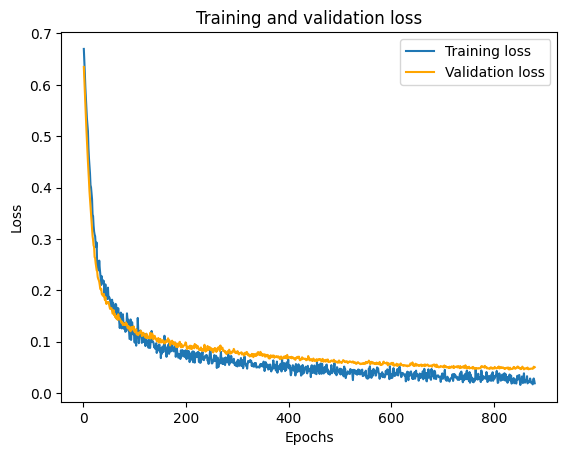

In [41]:
# let's see the training and validation accuracy by epoch
best_loss_values = best_history_dict['loss'] # you can change this
best_val_loss_values = best_history_dict['val_loss'] # you can also change this
epochs = range(1, len(best_loss_values) + 1) # range of X (no. of epochs)
plt.plot(epochs, best_loss_values, label='Training loss')
plt.plot(epochs, best_val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The curves of the training loss and validation loss, even if they still follow the same patterns, are more separated, indicating the fact that the model may be overfitting slighly (which will be confirmed with the next metrics that can be found below)

#### Comparison between the training loss and the accuracy throughout the epochs

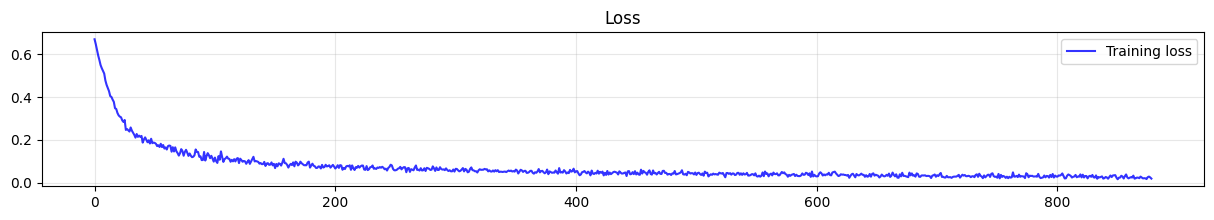

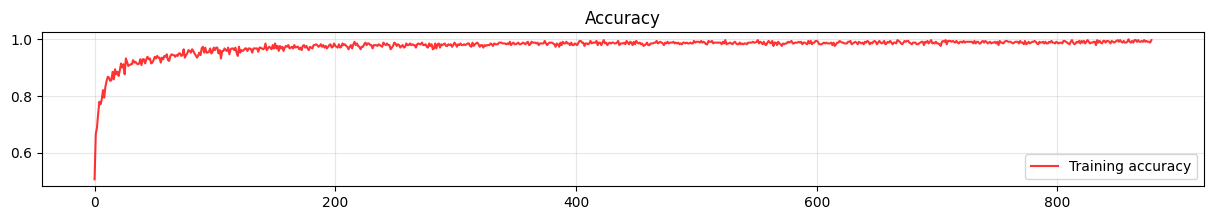

In [42]:
# Create a figure for the loss plot with specified figsize
plt.figure(figsize=(15, 2))

# Plot the training loss from the training history
plt.plot(best_history_dict['loss'], label='Training loss', alpha=.8, color='blue')

# Set title for the plot
plt.title('Loss')

# Add a legend to the plot
plt.legend()

# Add grid lines to the plot with specified transparency
plt.grid(alpha=.3)

# Create a new figure for the accuracy plot with specified figsize
plt.figure(figsize=(15, 2))

# Plot the training accuracy from the training history
plt.plot(best_history_dict['accuracy'], label='Training accuracy', alpha=.8, color='red')

# Set title for the plot
plt.title('Accuracy')

# Add a legend to the plot
plt.legend()

# Add grid lines to the plot with specified transparency
plt.grid(alpha=.3)

# Display the plots
plt.show()

These curves have the same pattern as the previous model.

### Performance on the different sets

#### Accuracy on the different sets

In [43]:
# Training set prediction
best_raw_predictions_train = best_MLPmodel.predict(X_train, verbose=0)
best_train_predictions = (best_raw_predictions_train > 0.5).astype(int).squeeze()

best_train_accuracy = accuracy_score(y_train, best_train_predictions)
print(f'Training accuracy: {best_train_accuracy}')

Training accuracy: 0.9941348973607038


In [44]:
# Validation set prediction
best_raw_predictions_val = best_MLPmodel.predict(X_val, verbose=0)
best_val_predictions = (best_raw_predictions_val > 0.5).astype(int).squeeze()

best_val_accuracy = accuracy_score(y_val, best_val_predictions)
print(f'Validation accuracy: {best_val_accuracy}')

Validation accuracy: 0.9912280701754386


In [45]:
# Testing set prediction
best_raw_predictions_test = best_MLPmodel.predict(X_test, verbose=0)
best_test_predictions = (best_raw_predictions_test > 0.5).astype(int).squeeze()

best_test_accuracy = accuracy_score(y_test, best_test_predictions)
print(f'Testing accuracy: {best_test_accuracy}')

Testing accuracy: 0.9473684210526315


The accuracy shows a slight overfitting, being the test set's accuracy slightly smaller than the train set's accuracy. However the difference is so little that it is not deemed problematic if this model was to be used on new data.

#### F1-score on the different sets

In [46]:
# Training set prediction
best_train_f1 = f1_score(y_train, best_train_predictions)
print(f'Training accuracy: {best_train_accuracy}')

Training accuracy: 0.9941348973607038


In [47]:
# Validation set prediction
best_val_accuracy = f1_score(y_val, best_val_predictions)
print(f'Validation accuracy: {best_val_accuracy}')

Validation accuracy: 0.993006993006993


In [48]:
# Testing set prediction
best_test_accuracy = f1_score(y_test, best_test_predictions)
print(f'Test accuracy: {best_test_accuracy}')

Test accuracy: 0.9571428571428572


As for the accuracy, the f1-score shows a little overfitting.